# VIT JAX naive implementation

In [1]:
# imports
import jax
from flax import nnx
import optax
import jax.numpy as jnp
import dataclasses

from typing import List, Dict

In [2]:
jax.devices()

[CudaDevice(id=0)]

## Configuration

In [35]:
@dataclasses.dataclass
class Config:
    # 
    num_patches:int = 16 # The image will be divided in num_patches_x_num_patches

    # Training parameters
    batch_size:int = 32
    # Dataset related parameters
    dataset_name:str = "zh-plus/tiny-imagenet"
    image_size:int = 64 # assume that every image is image_size_x_image_size

In [36]:
config = Config()

## Dataset

In [3]:
import datasets
from PIL import Image
from IPython.display import display

In [7]:
dataset=datasets.load_dataset(config.dataset_name, streaming=True)
dataset

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

IterableDatasetDict({
    train: IterableDataset({
        features: ['image', 'label'],
        n_shards: 1
    })
    valid: IterableDataset({
        features: ['image', 'label'],
        n_shards: 1
    })
})

In [24]:
batched_data =  dataset['train'].batch(config.batch_size, drop_last_batch=True).map(lambda x: {"image": jnp.array([jnp.array(i) for i in x["image"]]), "label": jnp.array(x["label"])})

In [27]:
for x in batched_data:
    break


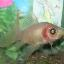

In [37]:
Image.frombytes('RGB', data=x['image'].tobytes(), size=(config.image_size, config.image_size))

In [30]:
# Calculate averages for whitenning
min_val = 255
max_val = 0
avg_sum = 0
avg_denom = 0
for step, batch in enumerate(batched_data):
    data = batch["image"]
    #print(jnp.min(data), jnp.max(data), jnp.sum(data), data.size)
    min_val = min(min_val, jnp.min(data))
    max_val = max(max_val, jnp.max(data))
    avg_sum += jnp.sum(data)
    avg_denom += data.size
    if step > 20:
        break
min_val, max_val, avg_sum, avg_denom

(Array(0, dtype=uint8),
 Array(255, dtype=uint8),
 Array(877874995, dtype=uint32),
 8650752)

In [31]:
def whitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.uint8
    return (img.astype(jnp.float32)-128.)/128

def dewhitenen(img: jax.Array) -> jax.Array:
    assert img.dtype == jnp.float32
    return (128.*img +128.).astype(jnp.uint8)

In [38]:
whtn_batched_data = batched_data.map(lambda x: {'image': whitenen(x['image'])})

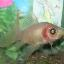

In [39]:
for wtn in whtn_batched_data:
    break
Image.frombytes('RGB', data=dewhitenen(wtn['image']).tobytes(), size=(config.image_size, config.image_size))

### Model

In [ ]:
class ViTTransformer(nnx.Module):
    """ A naive implementation of transformer """
    def __init__(self, config:Config, rngs:nnx.Rngs):
        super().__init__()
        self.mlp1 = nnx.Linear()
        self.mlp2 = nnx.Linear()